In [1]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import sys
import matplotlib.pyplot as plt
import random
sys.path.append('../../')

from dionn import DataSelector

In [2]:
# Fijar semillas
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 1. Data set MNIST

In [3]:
# Load data
(X_train, y_train), (X_val, y_val) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_plot=X_train
y_plot=y_train
#Flatten the images to make them one-dimensional vectors
X_train = X_train[..., tf.newaxis]
X_val = X_val[..., tf.newaxis]

# Encode the labels using OneHotEncoder
enc = OneHotEncoder(sparse_output=False)
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = enc.transform(y_val.reshape(-1, 1))

# Selection of training and validation data
num_samples_train = 10000
num_samples_val = int(num_samples_train / 6)

# Generate random indices for the training set
random_indices_train = np.random.choice(len(X_train), size= num_samples_train, replace=False)

# Generate random indices for the validation set
random_indices_val = np.random.choice(len(X_val), size=num_samples_val, replace=False)

X_train = X_train[random_indices_train]
y_train_encoded = y_train_encoded[random_indices_train]
X_plot=X_plot[random_indices_train]
y_plot=y_plot[random_indices_train]
X_val = X_val[random_indices_val]
y_val_encoded = y_val_encoded[random_indices_val]

print(f'Size training set: {X_train.shape}')
print(f'Size Val set: {X_val.shape}')
print(f'Size training labels: {y_train_encoded.shape}')
print(f'Size Val labels: {y_val_encoded.shape}')

Size training set: (10000, 28, 28, 1)
Size Val set: (1666, 28, 28, 1)
Size training labels: (10000, 10)
Size Val labels: (1666, 10)


## 2. Model

In [4]:
# Create the model
class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))
        self.maxpool_1 = tf.keras.layers.MaxPooling2D((2, 2))#
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.maxpool_2 = tf.keras.layers.MaxPooling2D((2, 2))#
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(128, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def inspector_out(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool_1(x)
        x = self.conv2(x)
        x = self.maxpool_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [5]:
# Instantiate the model
model_mnist = CustomModel()

## 3. First training phase: without filtering

In [6]:
# Training configuration
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_mnist.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      
                               patience=20,                
                               verbose=1,                   
                               mode='max',                  
                               restore_best_weights=True)  

In [7]:
# Training
model_mnist.fit(X_train, y_train_encoded, epochs=3000, batch_size=3000, verbose = 0, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 48.
Epoch 68: early stopping


### Results

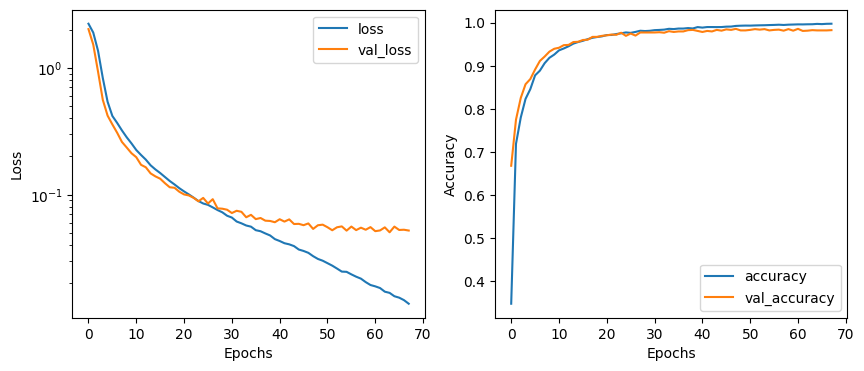

In [8]:
# Loss function graph and accuracy graph
plt.figure(figsize=(10, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(model_mnist.history.history['loss'], label='loss')
plt.plot(model_mnist.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Accuracy graph 
plt.subplot(1, 2, 2)
plt.plot(model_mnist.history.history['accuracy'], label='accuracy')
plt.plot(model_mnist.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [9]:
# Evaluation for the best weights for the model
loss_train, accuracy_train = model_mnist.evaluate(X_train, y_train_encoded, verbose=0)
loss_val, accuracy_val = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 0.03112589381635189
Train accuracy: 0.9926000237464905
Validation loss: 0.05358881503343582
Validation accuracy: 0.9855942130088806


## 4. Second training phase: with filtering

In [10]:
epochs = 20                    # Number of epochs
epoch_init_filter = 1          # Epoch at which the filter starts
update_period_in_epochs = 5    # Update period in epochs

In [11]:
# Instantiate data selector
data_selector = DataSelector(X_train, y_train_encoded, epoch_init_filter , update_period_in_epochs, filter_percentile=0.25, random_state=280296, train_with_outliers=False)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up the callback to save the best weights
checkpoint_filepath = 'model_checkpoint.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

In [13]:
# Dictionary to store the training information
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

In [14]:
X_clusterized = {}
x_index_filter = {}
index_original = {}
epochs_succ_filt = []

x_index_filter_aux = []

# Training loop
for epoch in range(epochs):
    # Get filtered training sets
    X_tr_aux, y_tr_aux, index_original_aux, x_index_aux, cluster_aux  = data_selector.get_train_data(epoch=epoch, model=model_mnist, outs_posibilities=list(np.unique(y_train)), explained_variance = 0.95)

    if not x_index_filter_aux == x_index_aux:
        X_clusterized[epoch] = cluster_aux
        index_original[epoch] = index_original_aux
        x_index_filter[epoch] = list(set(x_index_aux).difference(set(x_index_filter_aux)))
        x_index_filter_aux[:] = x_index_aux[:]
        epochs_succ_filt.append(epoch)
        
    # Fit the model
    history = model_mnist.fit(X_tr_aux, y_tr_aux, epochs=1, batch_size=3000, verbose=0, validation_data=(X_val, y_val_encoded), callbacks=[model_checkpoint_callback] )
    
    # Store the training information
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")

Epoch: 1
PCA realizado: se retuvo el 95.0% de la varianza con 12 componentes.
Usando Gaussian Mixture Model (GMM) para el clustering...
Tamaño del set de entrenamiento: 10000
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
PCA realizado: se retuvo el 95.0% de la varianza con 13 componentes.
Usando Gaussian Mixture Model (GMM) para el clustering...
Tamaño del set de entrenamiento: 10000
Cada clase tiene un único cluster asociado.
Número de probabilidades por debajo del umbral 0.1 para la clase 0:  22
Número de probabilidades por debajo del umbral 0.1 para la clase 1:  99
Número de probabilidades por debajo del umbral 0.1 para la clase 2:  4
Número de probabilidades por debajo del umbral 0.1 para la clase 3:  19
Número de probabilidades por debajo del umbral 0.1 para la clase 4:  11
Número de probabilidades por debajo del umbral 0.1 para la clase 5:  13
Número de probabilidades por debajo del umbral 0.1 para la clase 6:  27
Número de probabilidades por debajo del umbral 0.1 para la clase 7:

In [15]:
# Index for all detected IO
index_filter = [item for sublist in x_index_filter.values() for item in sublist]

print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_train.shape[0] - len(index_filter)}')

Initial sets training: 10000
Final sets training: 9689


### Results

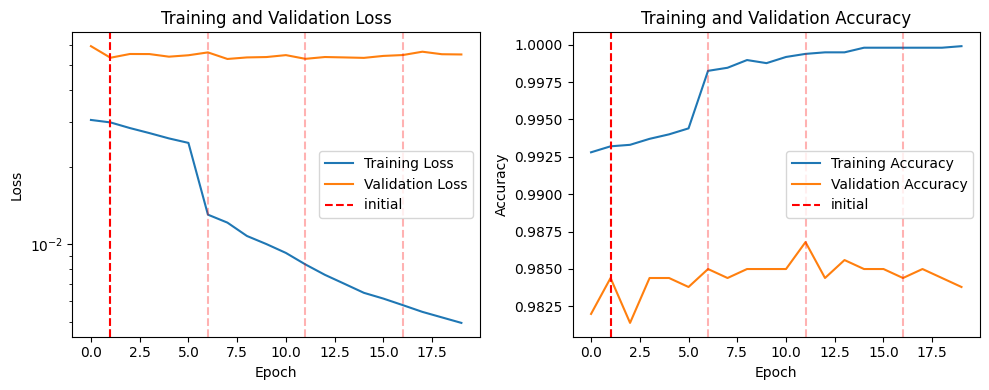

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial ')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='initial')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  # Líneas cada 5 epochs
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# Load best weights
model_mnist.load_weights(checkpoint_filepath)

# Evaluation Accuracy
loss_train_new, accuracy_train_new = model_mnist.evaluate(X_tr_aux, y_tr_aux, verbose=0)
loss_val_new, accuracy_val_new = model_mnist.evaluate(X_val, y_val_encoded, verbose=0)

print(f"Training loss: Previous {loss_train} vs current {loss_train_new}")
print(f"Training accuracy: Previous {accuracy_train} vs current {accuracy_train_new}")
print(f"Validation loss: Previous {loss_val} vs current {loss_val_new}")
print(f"Validation accuracy: Previous {accuracy_val} vs current {accuracy_val_new}")



Training loss: Previous 0.03112589381635189 vs current 0.007648396771401167
Training accuracy: Previous 0.9926000237464905 vs current 0.9994839429855347
Validation loss: Previous 0.05358881503343582 vs current 0.05278090760111809
Validation accuracy: Previous 0.9855942130088806 vs current 0.9867947101593018


## 5. Outliers Visualization

Intraclass-outliers detected in Epoch 6


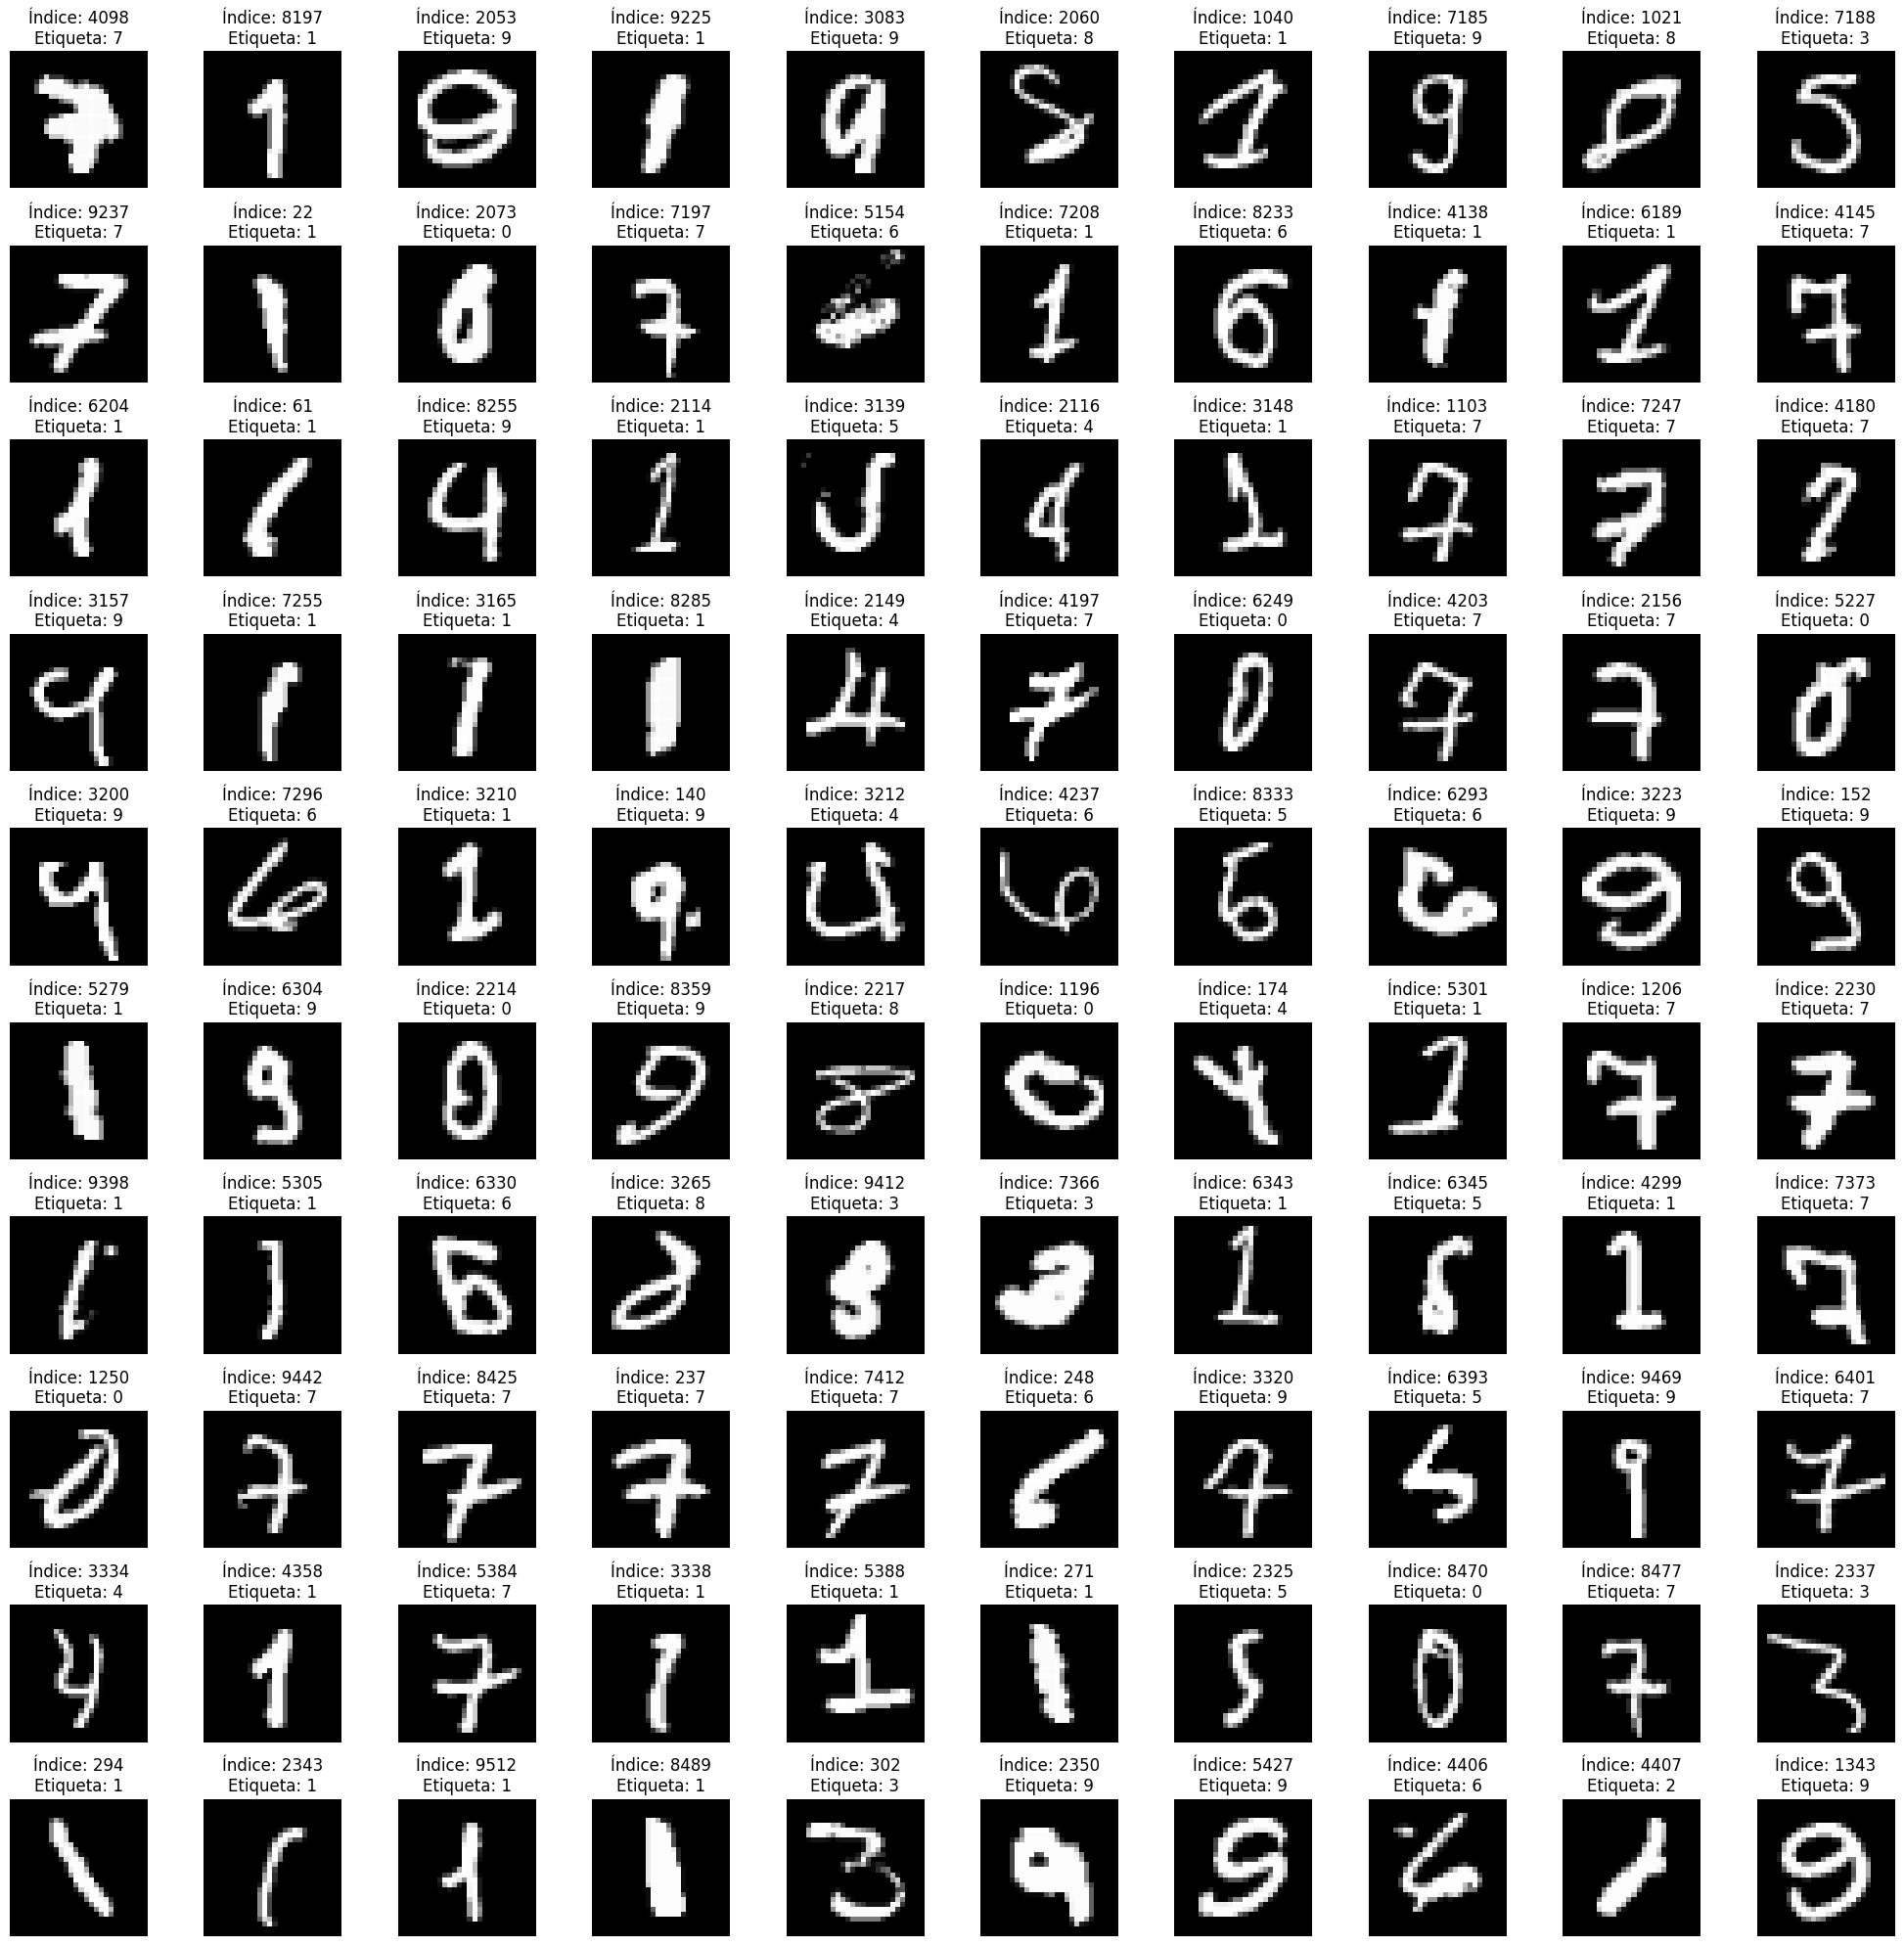

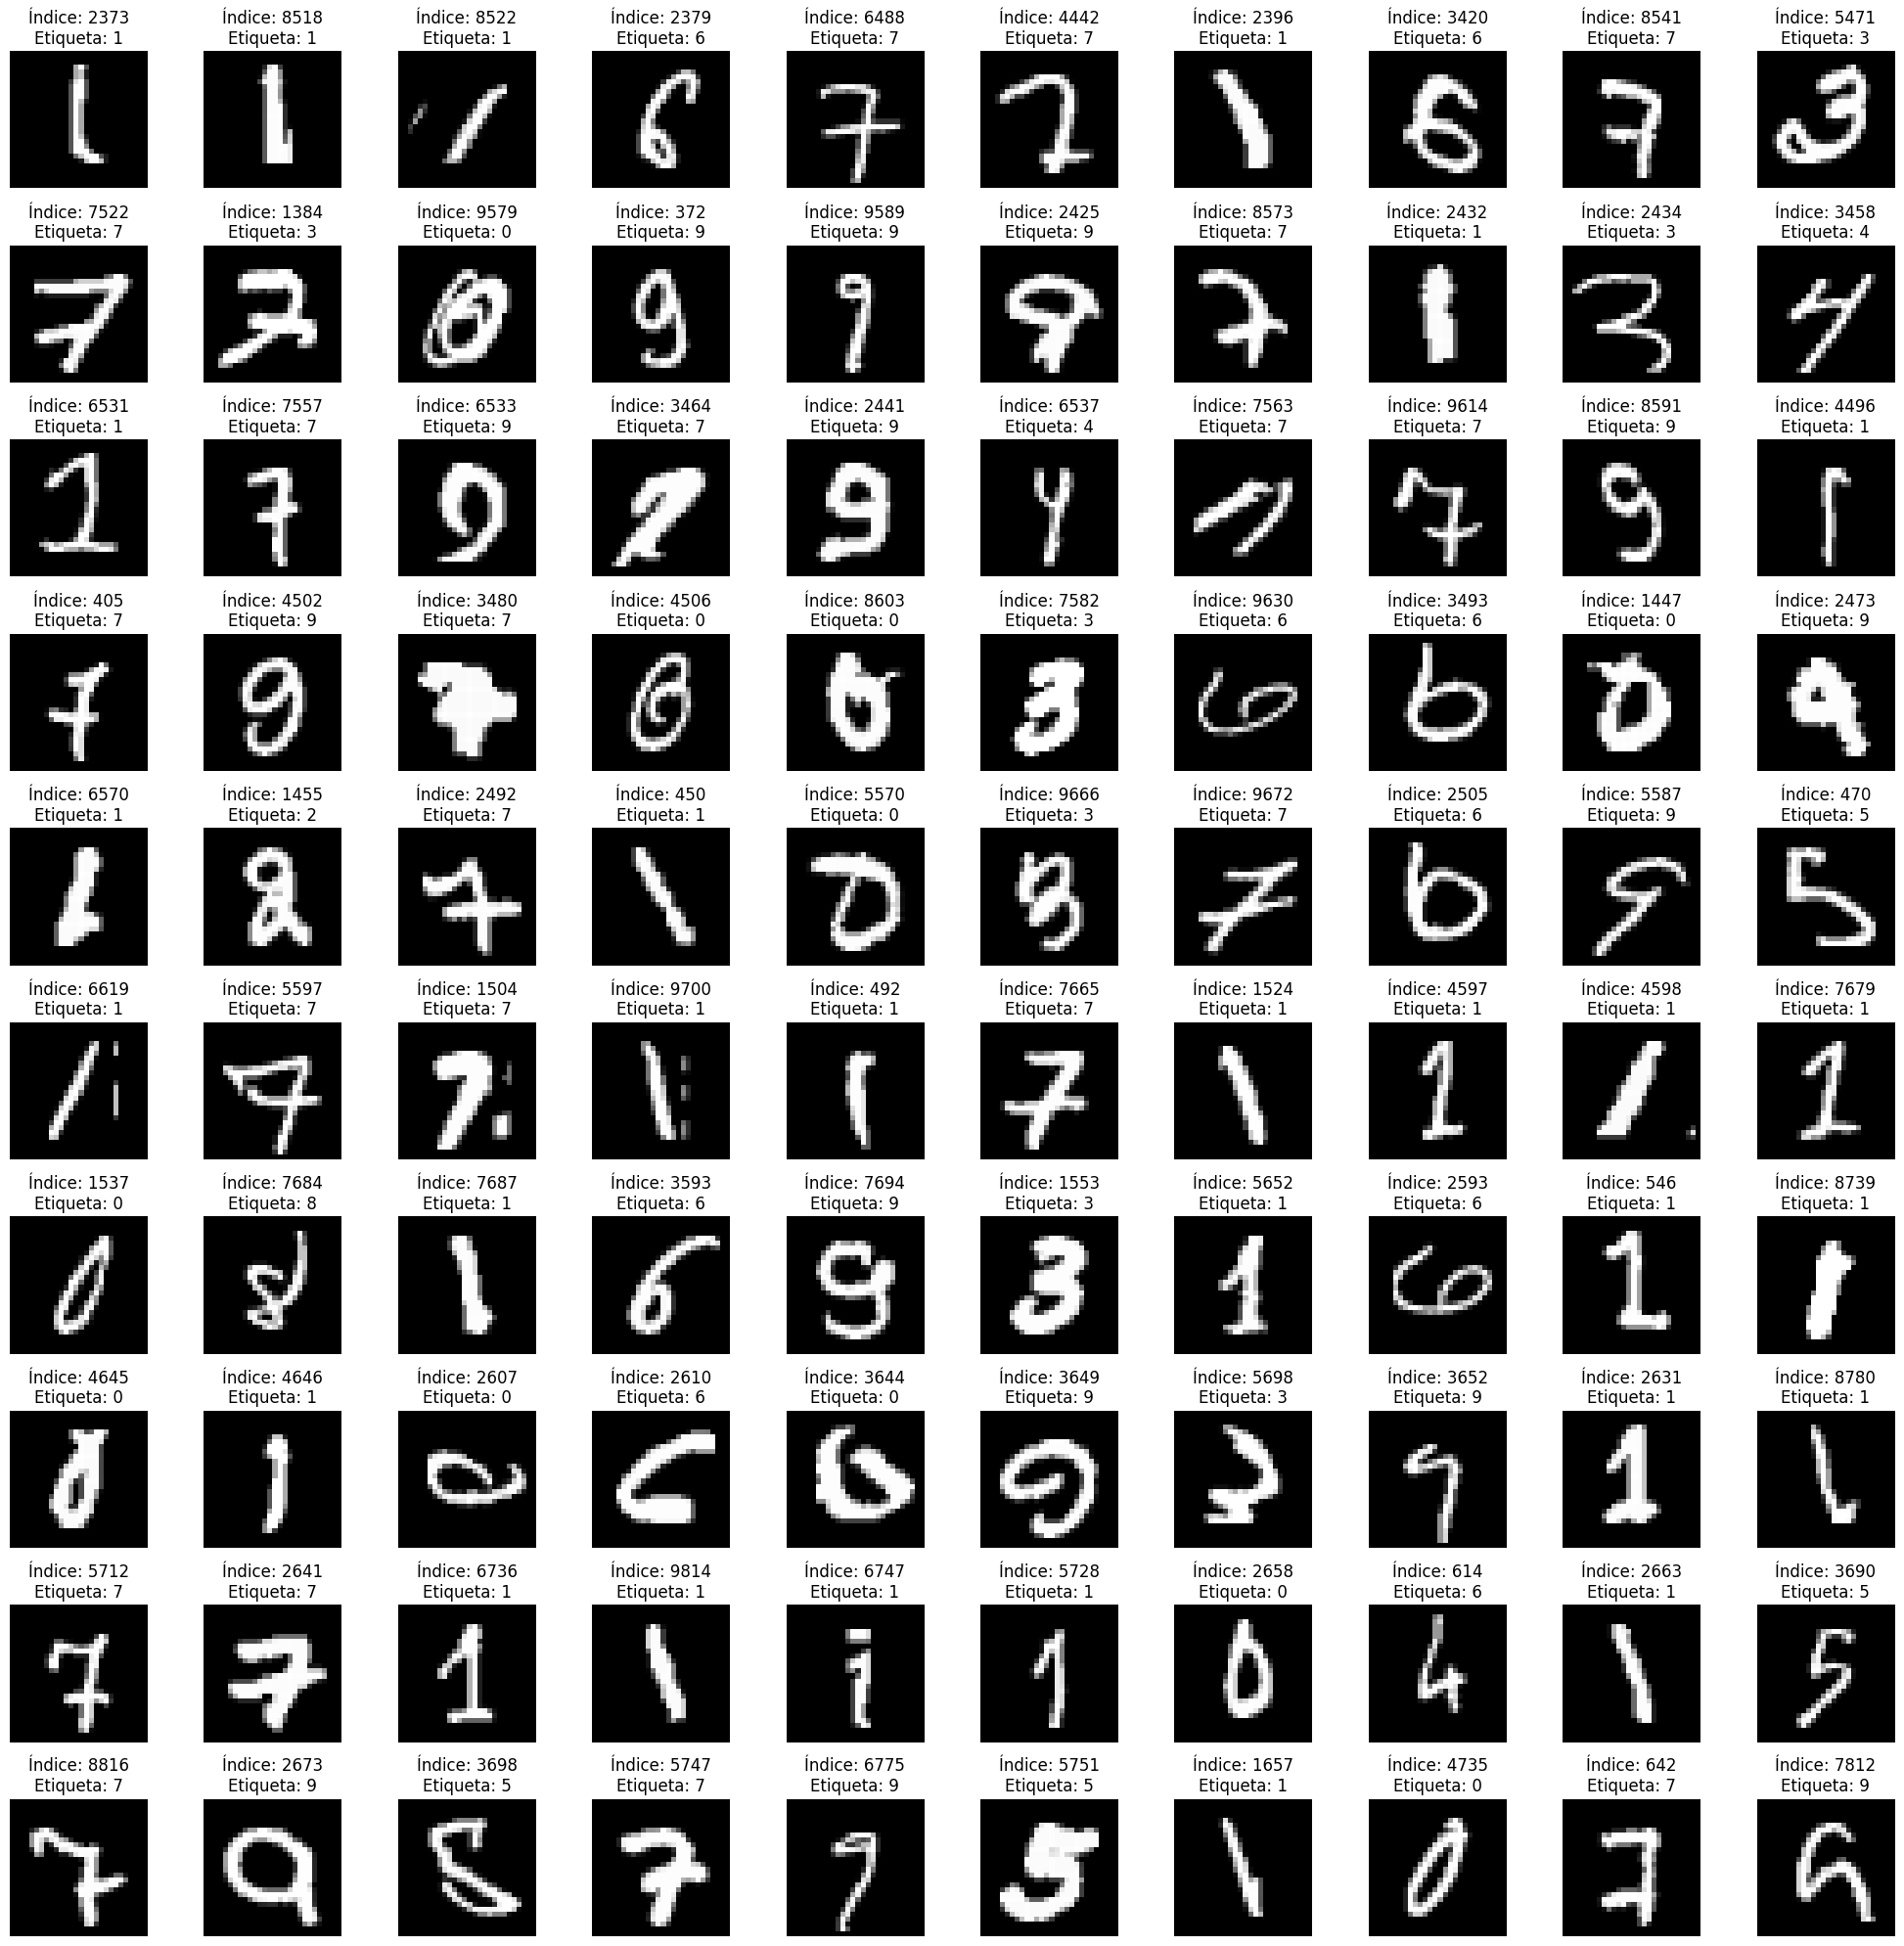

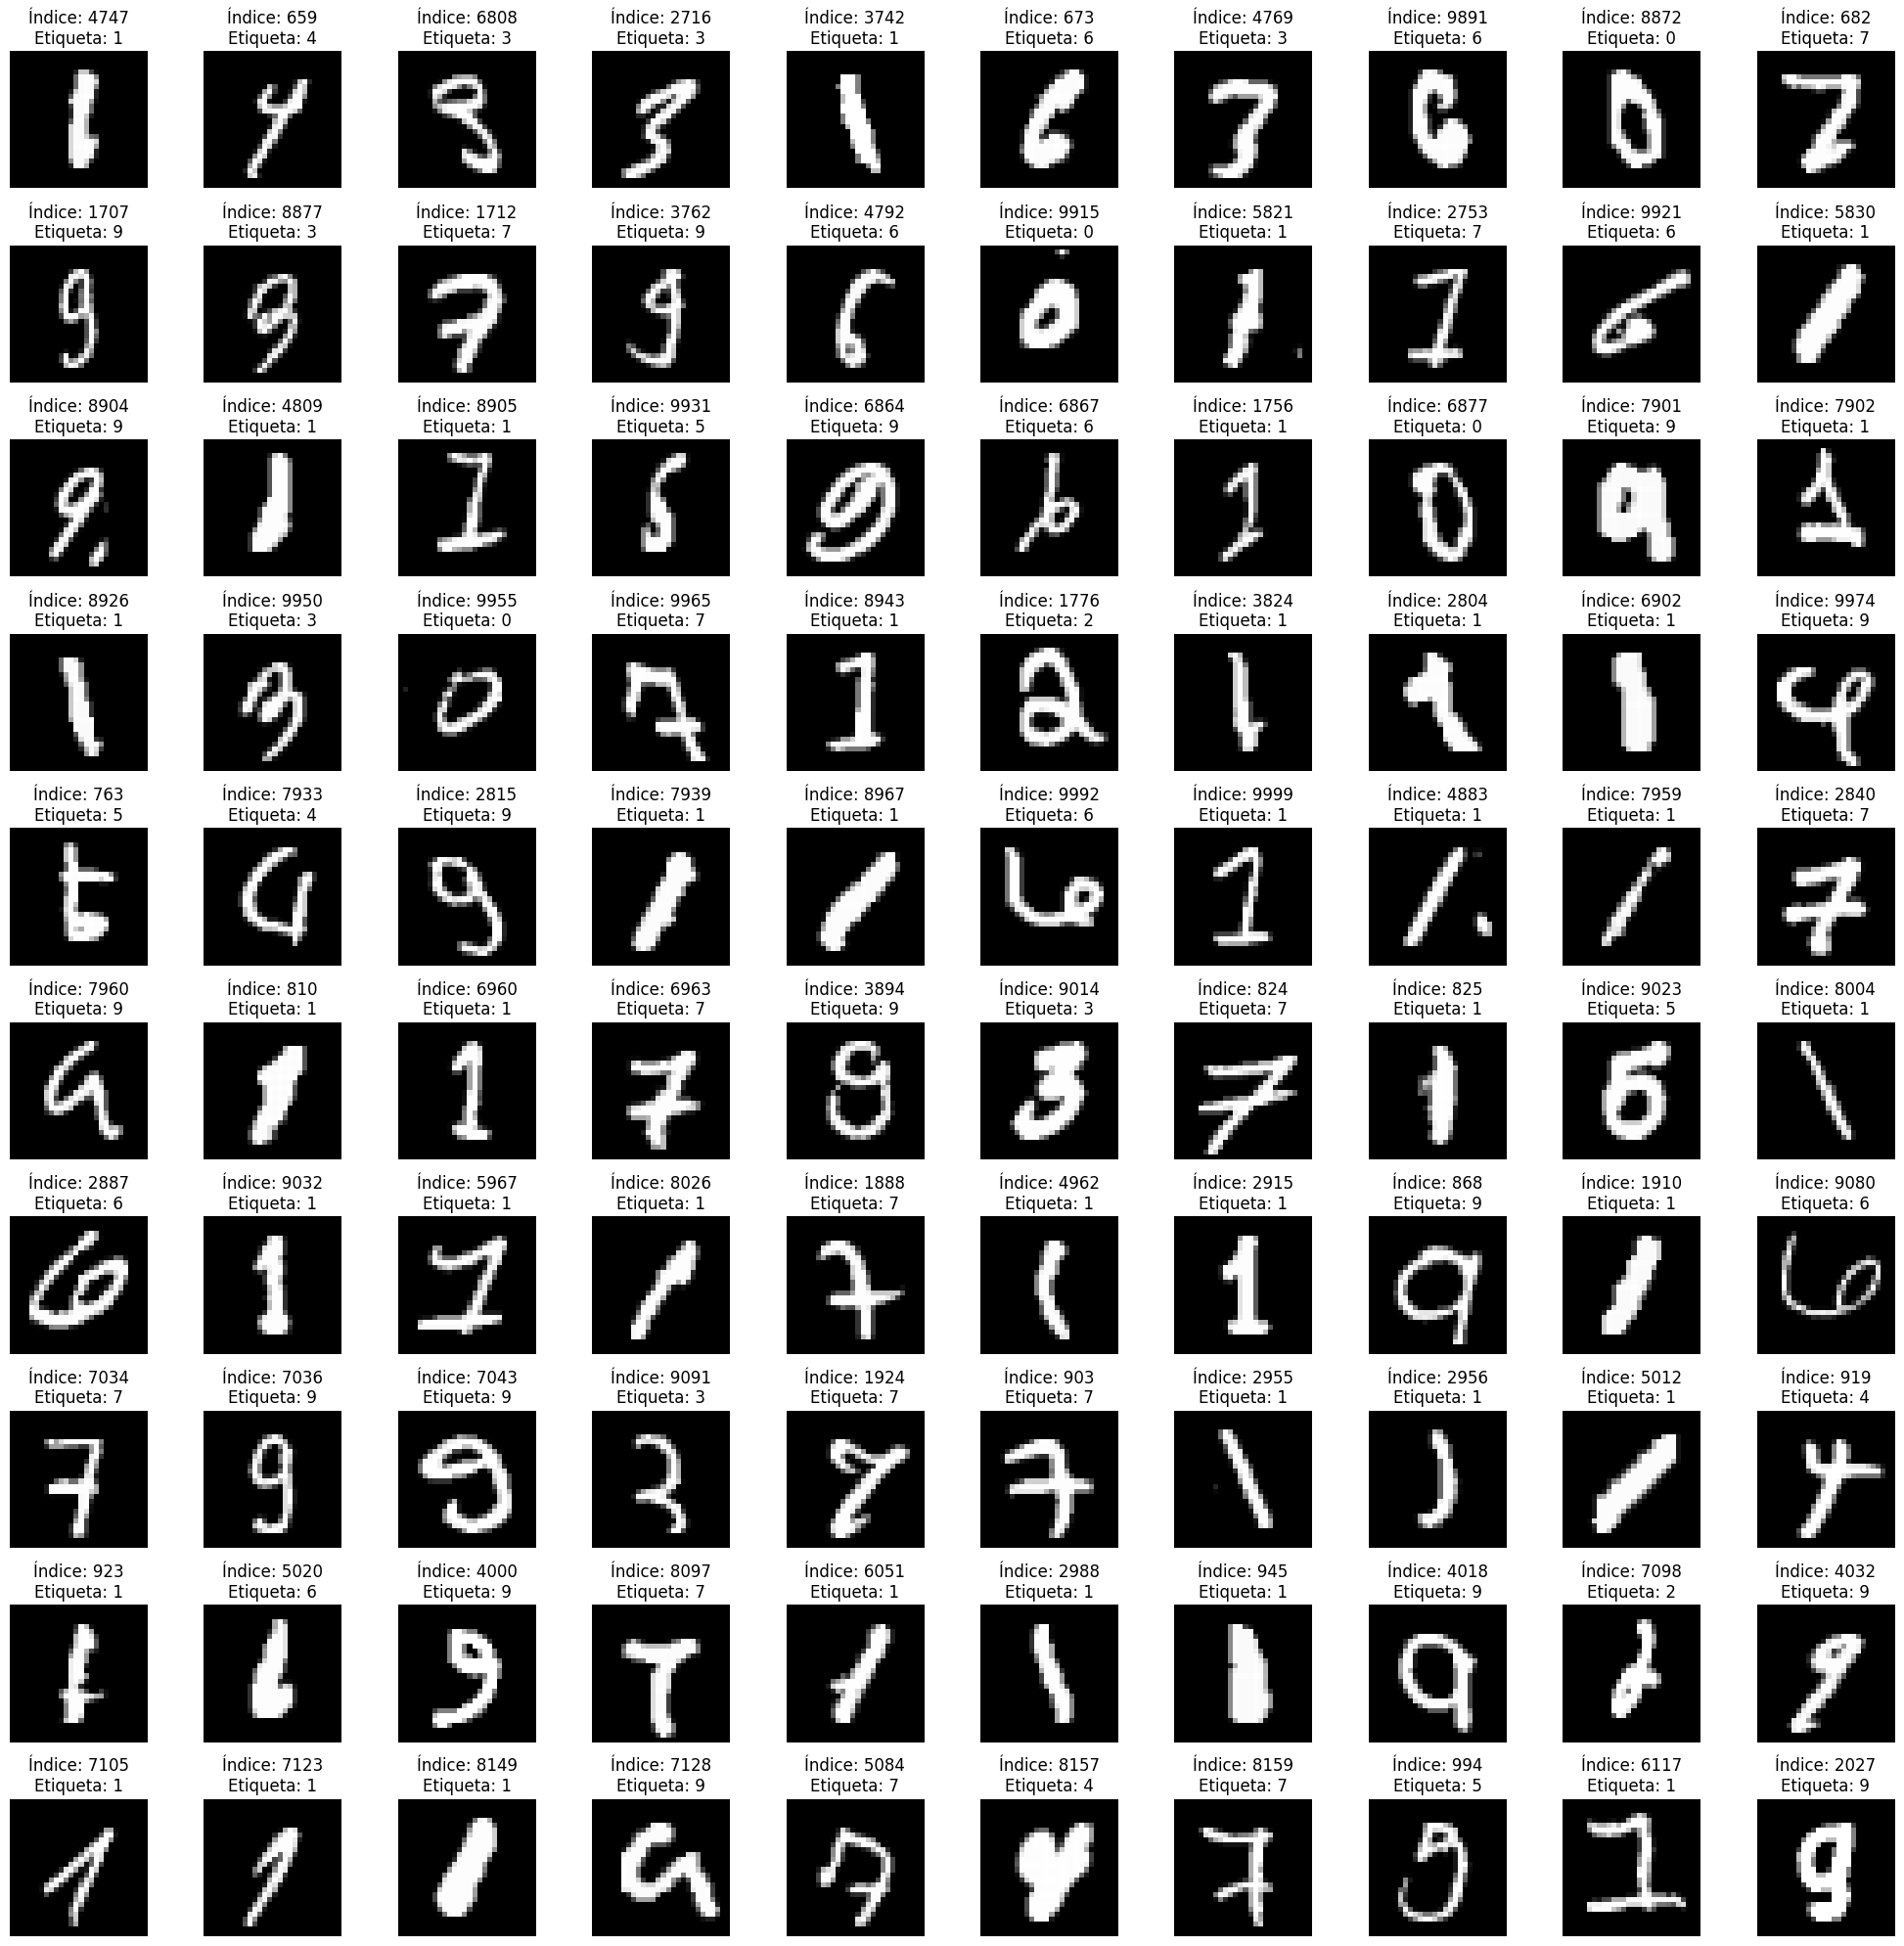

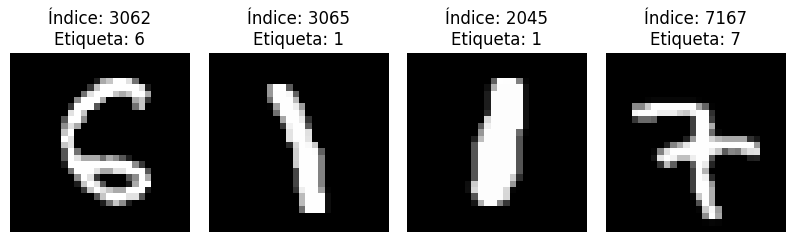

Intraclass-outliers detected in Epoch 11


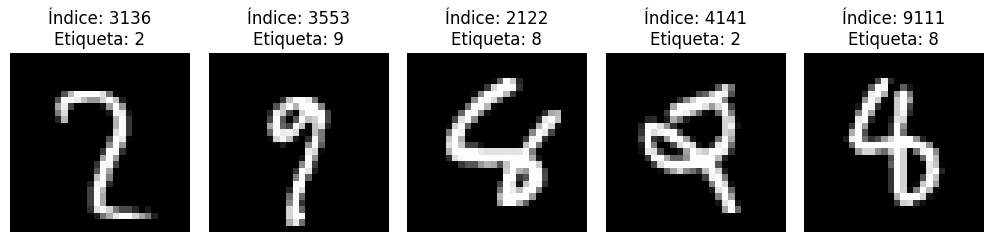

Intraclass-outliers detected in Epoch 16


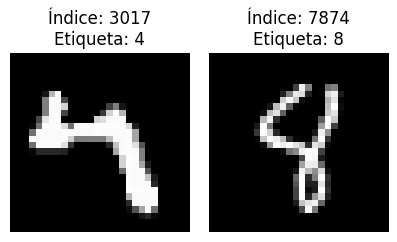

In [18]:
import math

for epoch in epochs_succ_filt:
    print(f'Intraclass-outliers detected in Epoch {epoch}')
    num_images = len(x_index_filter[epoch])
    grid_size = 10 
    
    num_figures = math.ceil(num_images / (grid_size * grid_size))
    
    for fig_num in range(num_figures):
        start_idx = fig_num * grid_size * grid_size
        end_idx = min(start_idx + grid_size * grid_size, num_images)
        
        plt.figure(figsize=(20, 20))
        for i, indice in enumerate(x_index_filter[epoch][start_idx:end_idx]):
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(X_plot[indice].reshape(28, 28), cmap='gray')
            plt.title(f'Índice: {indice}\nEtiqueta: {y_plot[indice]}', fontsize=12)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


→ Filtrado original: 9689 muestras
→ Contaminadas 294 etiquetas (1,2,8)→5
Índices contaminados: [1881 1487 1529 1618 1888 1391 1831 1673 1136 1566 1828 1411 1740 1542
 1038 1333 1847 1098 1120 1252 1635 1283 1720 1032 1317 1321 1069 1227
 1788 1101 1146 1670 1584 1904 1267 1772 1268 1791 1826 1285 1021 1260
 1630 1579 1332  985  992 1779  972 1476 1698 1560 1771 1513 1752 1296
 1199 1553 1160 1392 1325 1494 1366 1058 1545 1684 1903 1197 1274 1634
 1754 1001 1175 1444 1894 1028 1858 1029 1839 1447 1130 1280 1908 1324
 1543 1177 1929 1256 1050 1025 1782 1808 1559 1776 1172 1644 1778 1915
 1171 2630 2934 2676 2546 2532 2460 2084 2914 2046 2270 2915 2434 2420
 2093 2128 2924 2166 2003 2207 2022 2185 2193 2021 2080 2575 2539 2358
 2226 2363 2383 2642 1998 2454 2340 1985 2869 2730 2303 2596 2670 2012
 2756 2298 2339 2218 2636 2404 2526 2541 2819 2608 2629 2296 2208 2610
 2451 2443 2090 1991 2741 2049 2650 2931 2848 2026 2067 2428 2815 2935
 2355 2742 2167 2728 2272 2416 2262 2494 2406 2400 1

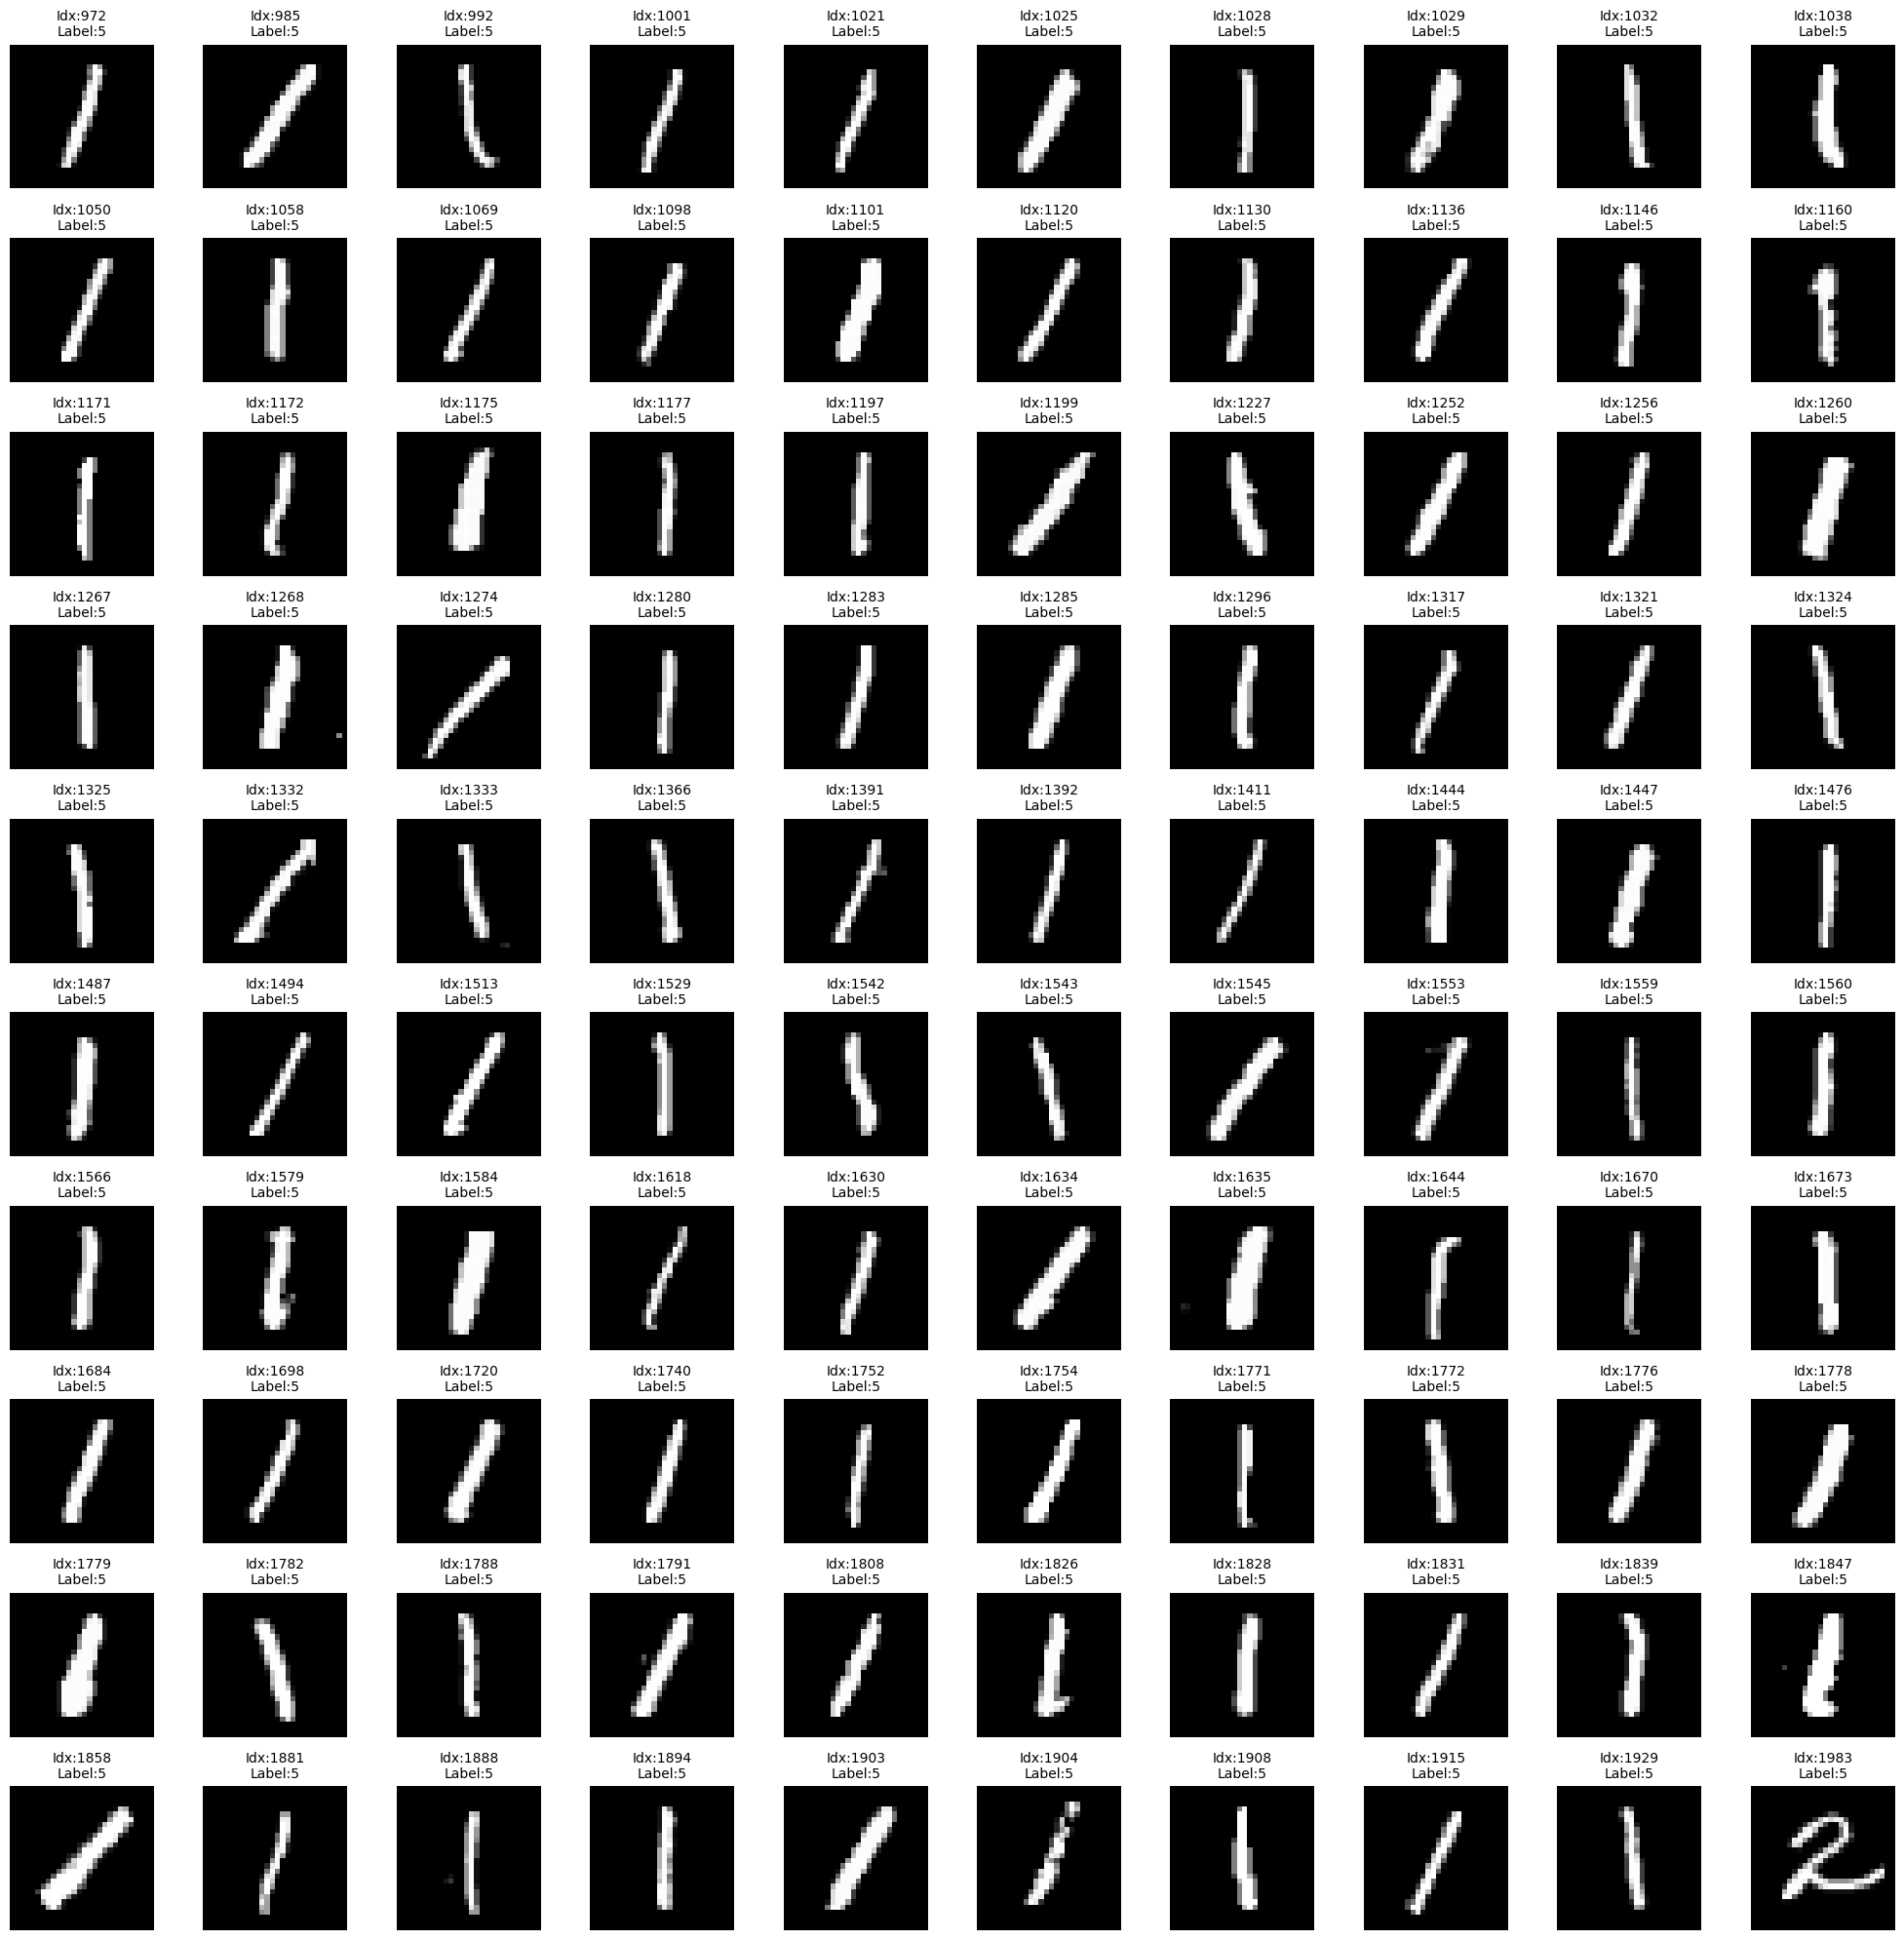

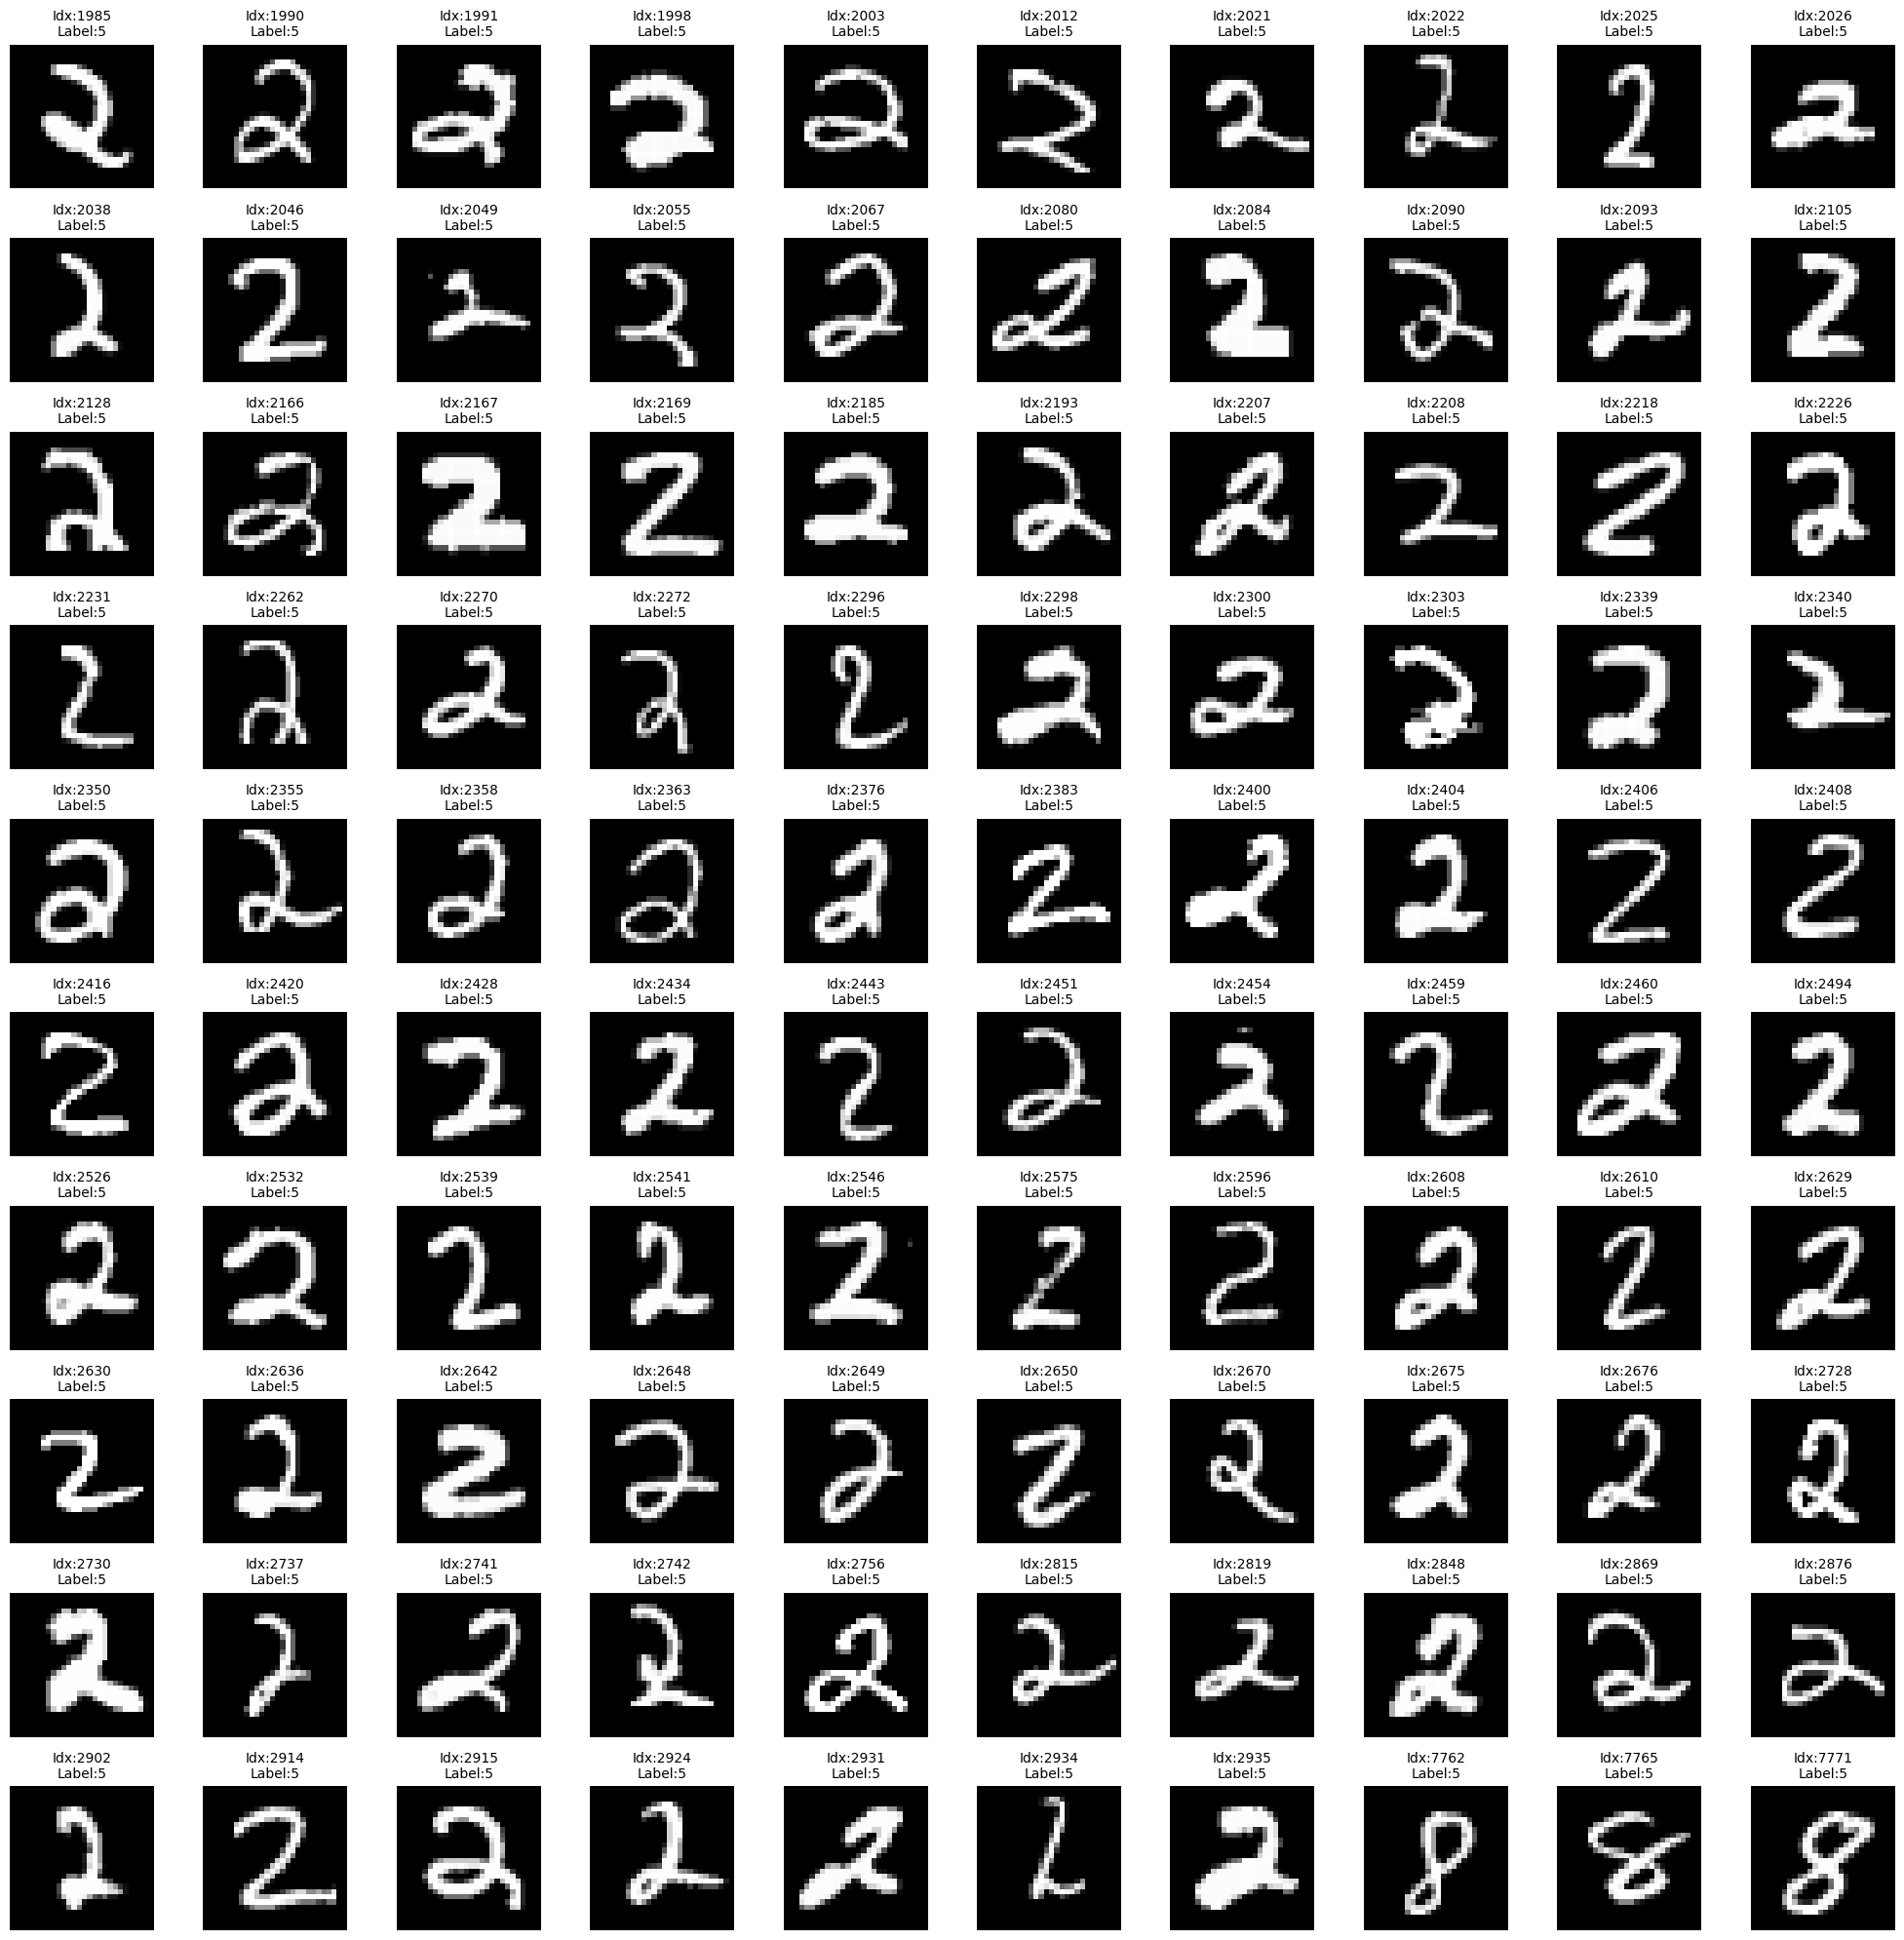

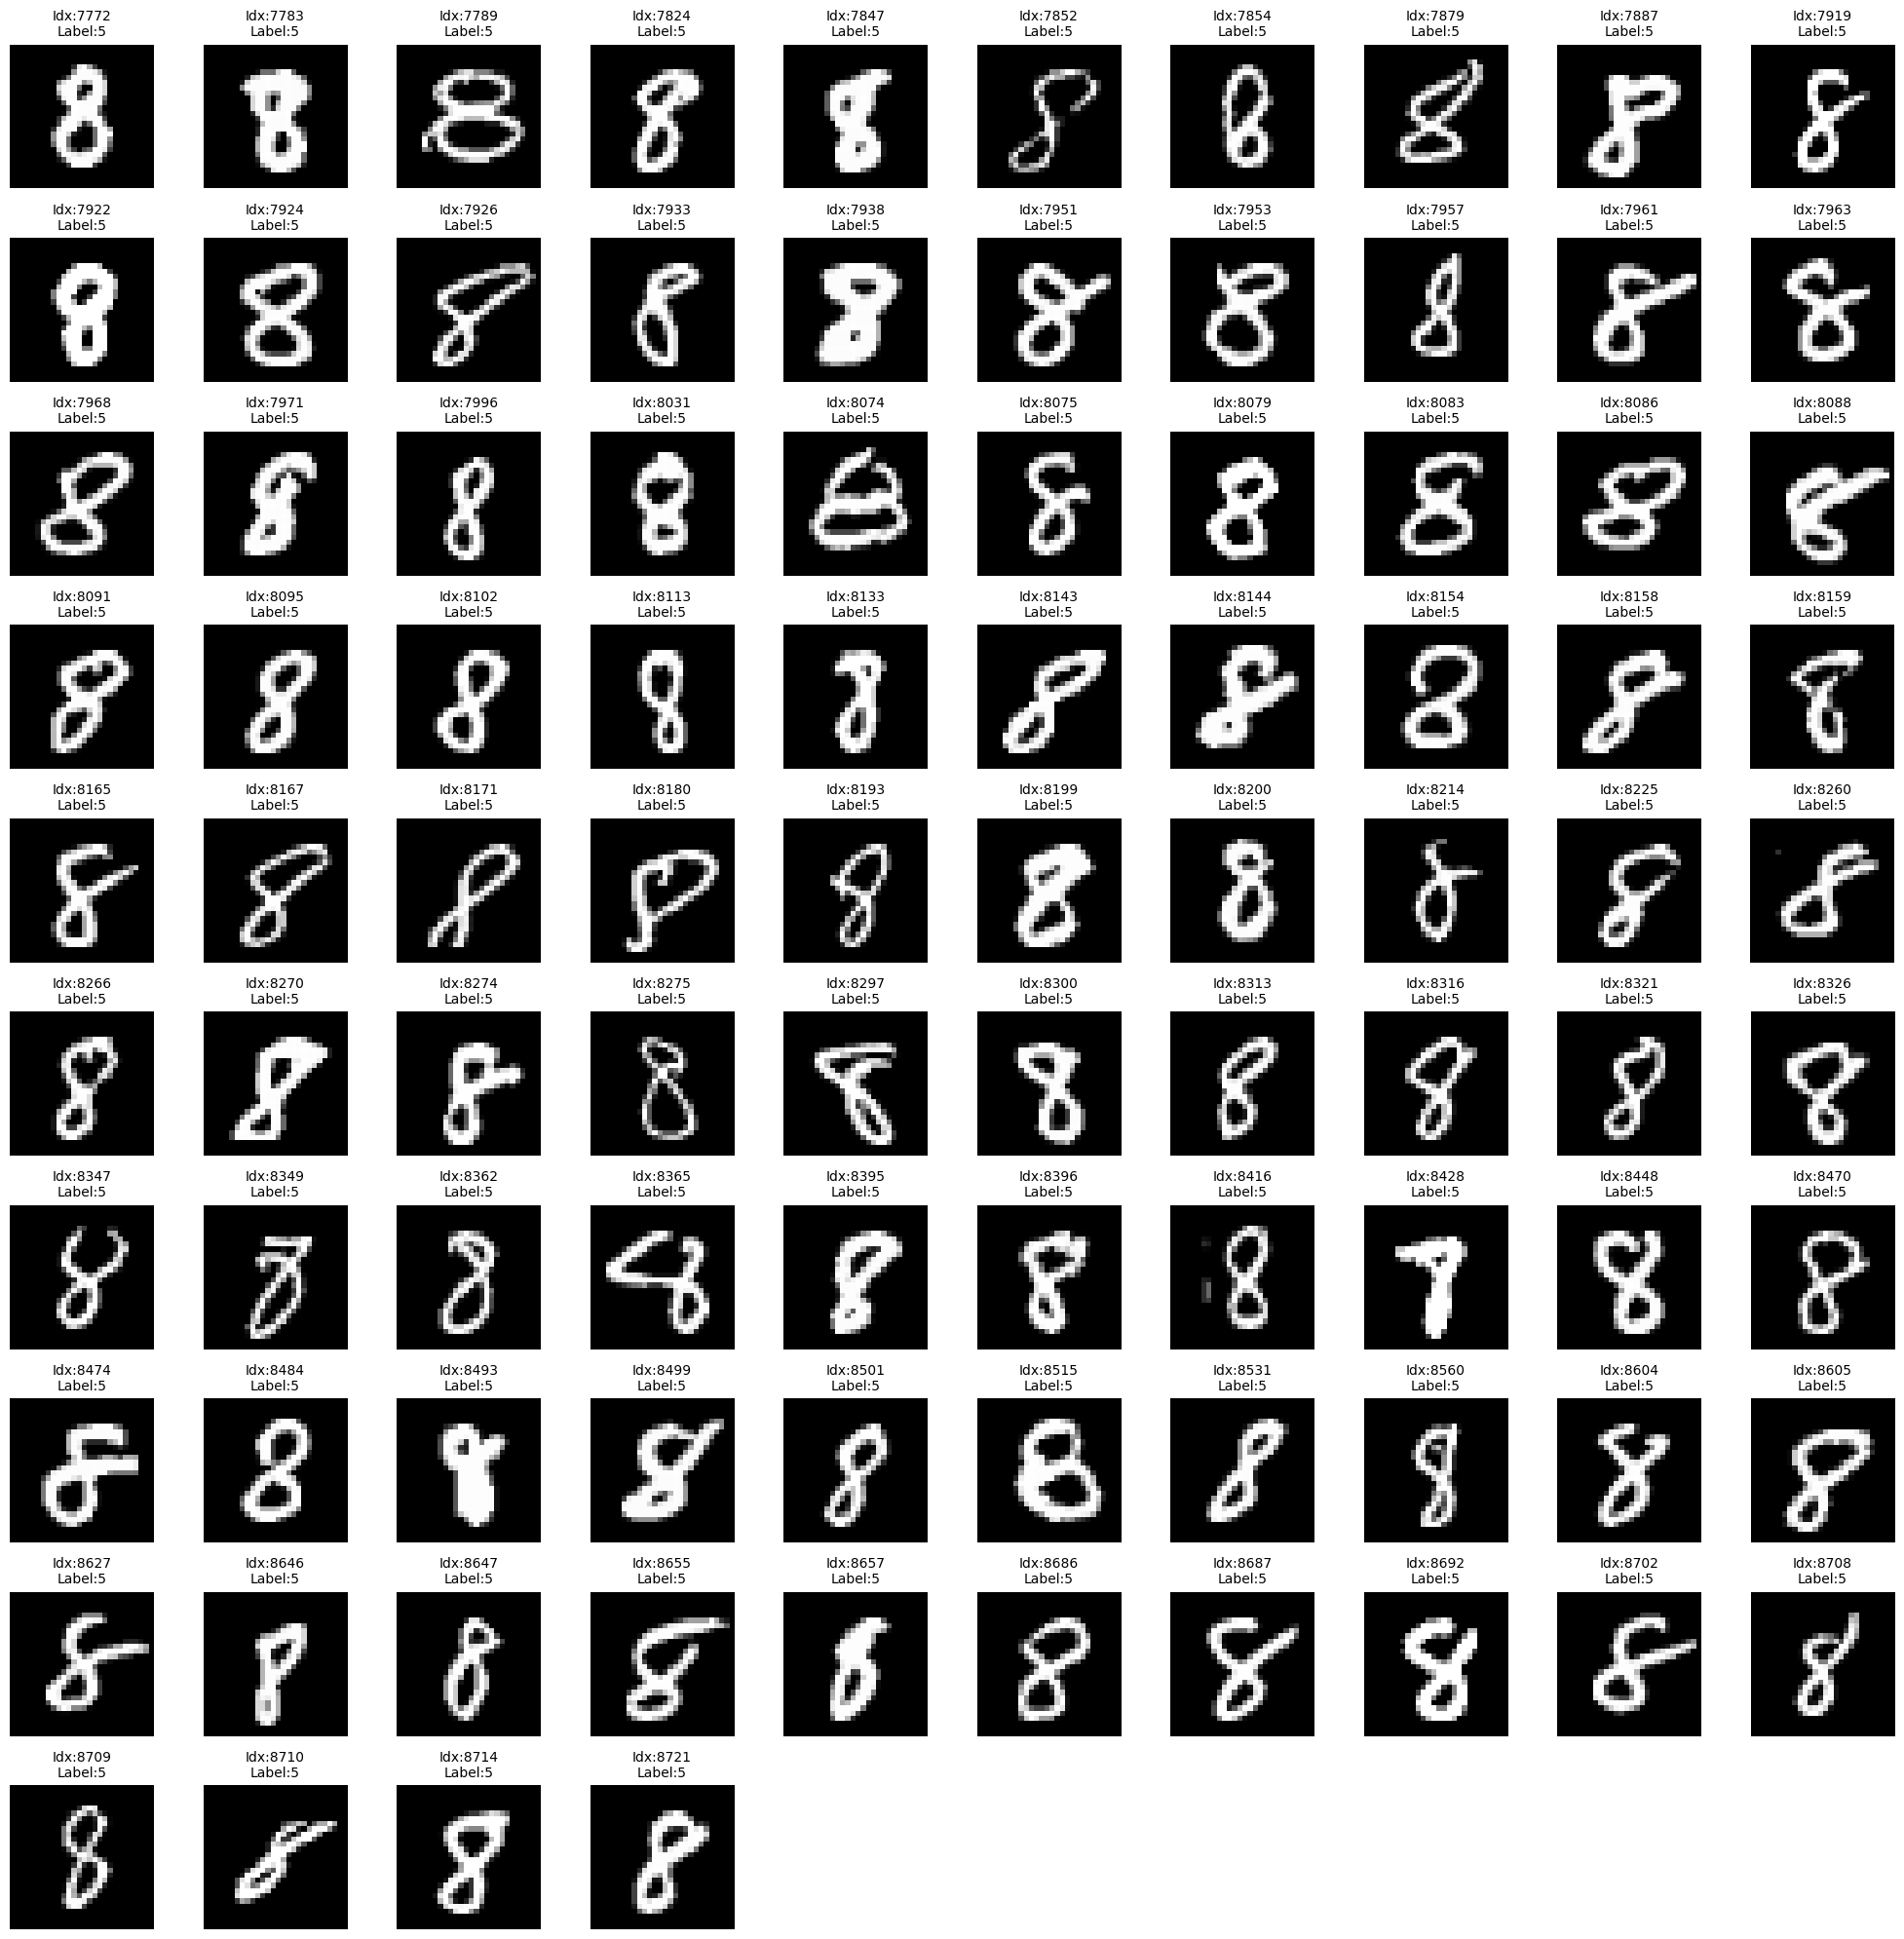

2º Run Epoch 7: se inyectaron 294 outliers, Dionn removió 21 total, de los cuales 0 fueron inyectados.
2º Run Epoch 12: se inyectaron 294 outliers, Dionn removió 7 total, de los cuales 0 fueron inyectados.
2º Run Epoch 17: se inyectaron 294 outliers, Dionn removió 2 total, de los cuales 0 fueron inyectados.


In [19]:
y_filtered_int = np.argmax(y_tr_aux, axis=1)  # shape (n_samples_filtered,)

# X_tr_aux ya es numpy array; lo renombramos para el segundo paso
X_filtered = X_tr_aux
y_filtered = y_filtered_int

# Copias para plot del dataset filtrado (asegurar numpy)
if isinstance(X_filtered, tf.Tensor):
    X_plot_f = X_filtered.numpy().copy()
else:
    X_plot_f = X_filtered.copy()
y_plot_f = y_filtered.copy()

# --- PASO C: Contaminar etiquetas 1,2,8 → 5 en este dataset filtrado ---
def contaminar_con_outliers_multi(y_data, etiquetas_originales, etiqueta_outlier, ratio, seed=None):
    np.random.seed(seed)
    y_mod = y_data.copy()
    changed = []
    for e in etiquetas_originales:
        idx = np.where(y_mod == e)[0]
        n = int(len(idx) * ratio)
        if n > 0:
            sel = np.random.choice(idx, size=n, replace=False)
            y_mod[sel] = etiqueta_outlier
            changed.extend(sel.tolist())
    return y_mod, np.array(changed)

outlier_ratio = 0.1
y_filtered_cont, changed_filtered_idx = contaminar_con_outliers_multi(
    y_filtered,
    etiquetas_originales=[1, 2, 8],
    etiqueta_outlier=5,
    ratio=outlier_ratio,
    seed=42
)

# Para los plots, actualizo las etiquetas reales
y_plot_f = y_filtered_cont.copy()

print(f"→ Filtrado original: {len(y_filtered)} muestras")
print(f"→ Contaminadas {len(changed_filtered_idx)} etiquetas (1,2,8)→5")
print("Índices contaminados:", changed_filtered_idx)

# --- PASO D: One-hot encode de este dataset contaminado ---
y_filtered_enc = enc.fit_transform(y_filtered_cont.reshape(-1, 1))

# --- PASO E: Nuevo DataSelector sobre el dataset contaminado ---
data_selector2 = DataSelector(
    X_filtered,
    y_filtered_enc,
    epoch_init_filter,
    update_period_in_epochs,
    filter_percentile=0.25,
    random_state=280296,
    train_with_outliers=False
)

# --- PASO F: Segundo bucle de filtrado + entrenamiento ---
X_cluster2      = {}
x_index_filter2 = {}
index_original2 = {}
epochs_succ2    = []
x_idx_aux2      = []

for epoch in range(epochs):
    X_tr2, y_tr2_onehot, idx_orig2, x_idx2, cluster2 = data_selector2.get_train_data(
        epoch=epoch,
        model=model_mnist,
        outs_posibilities=list(np.unique(y_filtered_cont)),
        explained_variance=0.95
    )

    if x_idx_aux2 != x_idx2:
        X_cluster2[epoch]      = cluster2
        index_original2[epoch] = idx_orig2
        x_index_filter2[epoch] = list(set(x_idx2) - set(x_idx_aux2))
        x_idx_aux2[:]          = x_idx2[:]
        epochs_succ2.append(epoch)

        # ¿Cuántos de tus outliers contaminados fueron detectados?
        detected2 = np.intersect1d(x_index_filter2[epoch], changed_filtered_idx)
        print(f"[2º Run Epoch {epoch+1}] Outliers detectados: {len(detected2)} / {len(changed_filtered_idx)} inyectados")

    # Entrenar 1 época
    history2 = model_mnist.fit(
        X_tr2, y_tr2_onehot,
        epochs=1,
        batch_size=3000,
        verbose=0,
        validation_data=(X_val, y_val_encoded),
        callbacks=[model_checkpoint_callback]
    )

    train_info['train_losses'].append(history2.history['loss'])
    train_info['val_losses'].append(history2.history['val_loss'])
    train_info['train_accuracies'].append(history2.history['accuracy'])
    train_info['val_accuracies'].append(history2.history['val_accuracy'])

    print(f"2º Run Epoch completo: {epoch+1}")

# --- PASO G: Visualizar los que se removieron (tus inyectados) en cada época ---
import math

for epoch in epochs_succ2:
    removed_injected2 = np.intersect1d(x_index_filter2[epoch], changed_filtered_idx)
    print(f'2º Run Epoch {epoch+1}: se inyectaron {len(changed_filtered_idx)} outliers, '
          f'Dionn removió {len(x_index_filter2[epoch])} total, '
          f'de los cuales {len(removed_injected2)} fueron inyectados.')

    if len(removed_injected2) == 0:
        continue

    grid = 10
    imgs = len(removed_injected2)
    figs = math.ceil(imgs / (grid * grid))
    for f in range(figs):
        s = f * grid * grid
        e = min(s + grid*grid, imgs)
        batch = removed_injected2[s:e]

        plt.figure(figsize=(20,20))
        for i, idx in enumerate(batch):
            plt.subplot(grid, grid, i+1)
            plt.imshow(X_plot_f[idx].reshape(28,28), cmap='gray')
            plt.title(f'Idx:{idx}\nLabel:{y_plot_f[idx]}', fontsize=10)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

### Visualization with three PCA components

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(model_mnist.inspector_out(X_train))

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['class'] = y_train[random_indices_train]
df_pca['outlier'] = 'Normal'
df_pca.loc[index_filter, 'outlier'] = 'Outlier'

# Scatter plot of the original dataset
fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', color='class',
                    title='PCA of MNIST',
                    labels={'class': 'Numbers'},
                    opacity=0.7)

# Highlight the points that were filtered (detected outliers)
fig.add_trace(go.Scatter3d(
    x=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA1'],
    y=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA2'],
    z=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA3'],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Outliers'
))

# Update the chart design
fig.update_layout(scene=dict(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    zaxis_title='PCA Component 3'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=1
    )
)

fig.show()